In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb


In [3]:
train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [4]:
train_df.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [5]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [6]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [7]:
train_df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

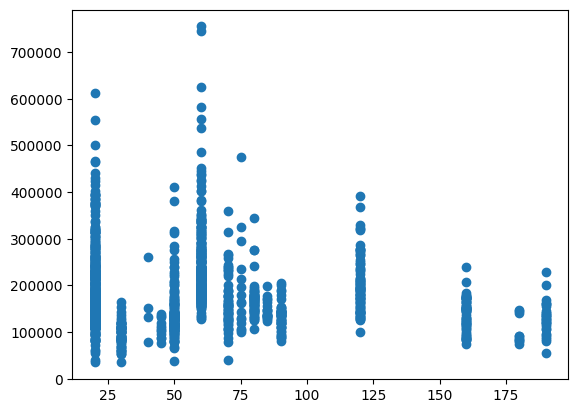

In [8]:
plt.scatter(x='MSSubClass', y='SalePrice', data=train_df)

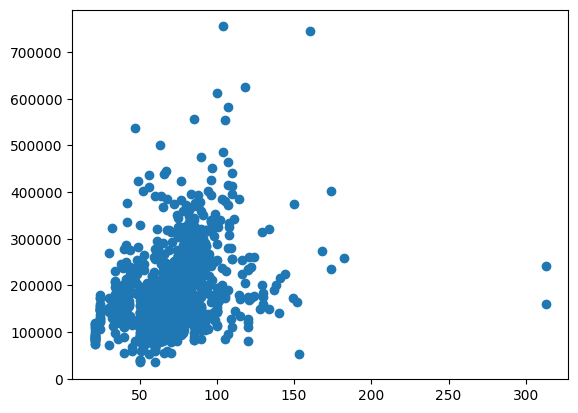

In [9]:
plt.scatter(x='LotFrontage', y='SalePrice', data=train_df)

In [10]:
train_df.query('LotFrontage > 300') # to check for outliers

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
934,935,20,RL,313.0,27650,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,11,2008,WD,Normal,242000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


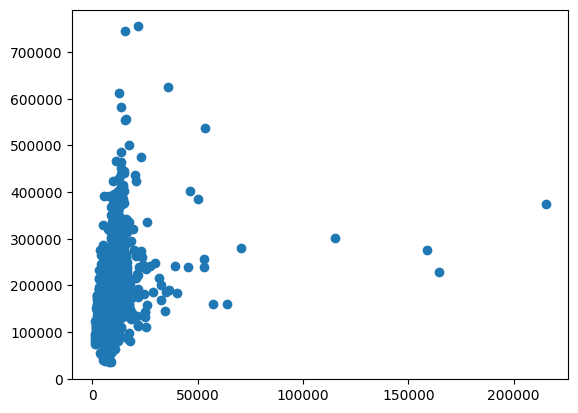

In [11]:
plt.scatter(x='LotArea', y='SalePrice', data=train_df)

In [12]:
train_df.query('LotArea > 55000')#to check for ouliers

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
249,250,50,RL,NaN,159000,Pave,NaN,IR2,Low,AllPub,...,0,NaN,NaN,Shed,500,6,2007,WD,Normal,277000
313,314,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000
335,336,190,RL,NaN,164660,Grvl,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,Shed,700,8,2008,WD,Normal,228950
451,452,20,RL,62.0,70761,Pave,NaN,IR1,Low,AllPub,...,0,NaN,NaN,NaN,0,12,2006,WD,Normal,280000
706,707,20,RL,NaN,115149,Pave,NaN,IR2,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,302000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
1396,1397,20,RL,NaN,57200,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,160000


In [13]:
stats.zscore(train_df['LotArea']).sort_values().tail(10)#calculating zscores of a particular columns and then then sorting and displaying the largest 10 z-scores

384      4.268474
457      4.280500
769      4.308262
1396     4.678682
1298     5.348867
451      6.037793
706     10.486449
249     14.881285
335     15.448542
313     20.518273
Name: LotArea, dtype: float64

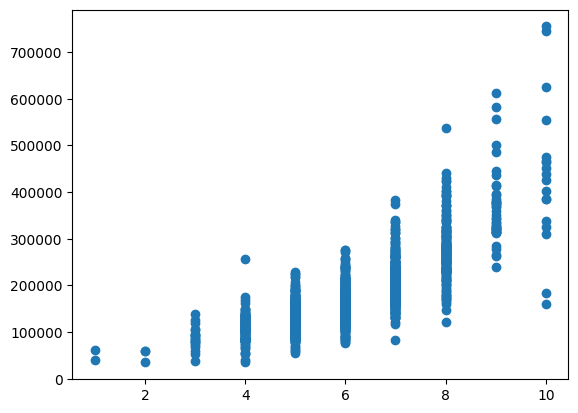

In [14]:
plt.scatter(x='OverallQual', y='SalePrice', data=train_df)

In [15]:
train_df.query('OverallQual == 10')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
58,59,60,RL,66.0,13682,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,10,2006,New,Partial,438780
185,186,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000
224,225,20,RL,103.0,13472,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,386250
389,390,60,RL,96.0,12474,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2008,New,Partial,426000
440,441,20,RL,105.0,15431,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,555000
515,516,20,RL,94.0,12220,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2009,New,Partial,402861
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
583,584,75,RM,75.0,13500,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,325000
591,592,60,RL,97.0,13478,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,ConLI,Normal,451950
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000


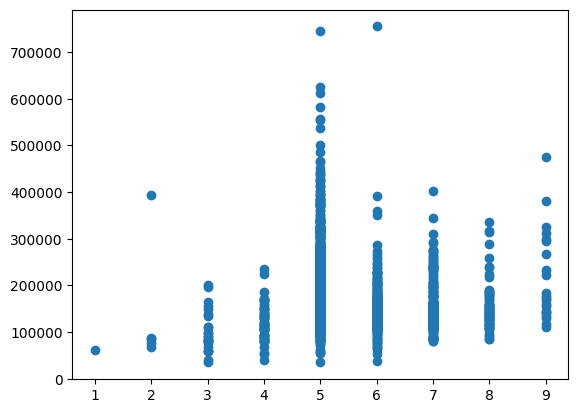

In [16]:
plt.scatter(x='OverallCond', y='SalePrice', data=train_df)


In [17]:
train_df.query('OverallCond == 2')#379

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
88,89,50,C (all),105.0,8470,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,10,2009,ConLD,Abnorml,85000
250,251,30,RL,55.0,5350,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,GdWo,Shed,450,5,2010,WD,Normal,76500
378,379,20,RL,88.0,11394,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,New,Partial,394432
398,399,30,RM,60.0,8967,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2007,WD,Abnorml,67000
676,677,70,RM,60.0,9600,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2006,WD,Normal,87000


In [18]:
train_df.query('OverallCond == 5 & SalePrice > 700000')
#1183

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000


In [19]:
train_df.query('OverallCond == 6 & SalePrice > 700000')
#692

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000


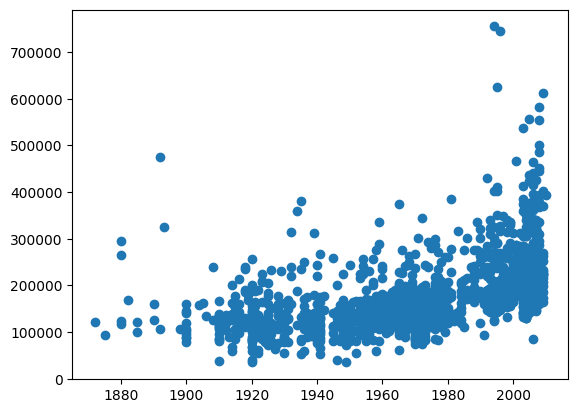

In [20]:
plt.scatter(x='YearBuilt', y='SalePrice', data=train_df)


In [21]:
train_df.query('YearBuilt < 1900 & SalePrice > 400000')
#186

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
185,186,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000


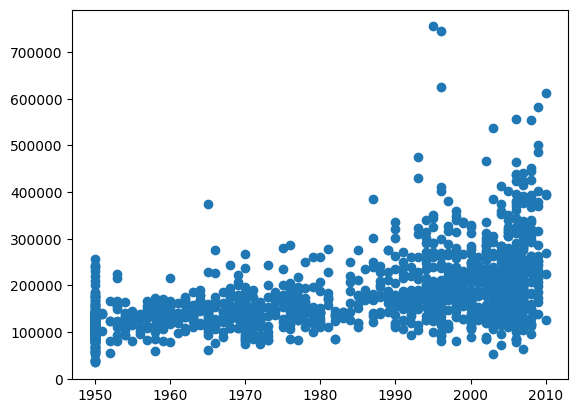

In [22]:
plt.scatter(x='YearRemodAdd', y='SalePrice', data=train_df)

In [23]:
train_df.query('YearRemodAdd < 1970 & SalePrice > 300000')
#314

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
313,314,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000


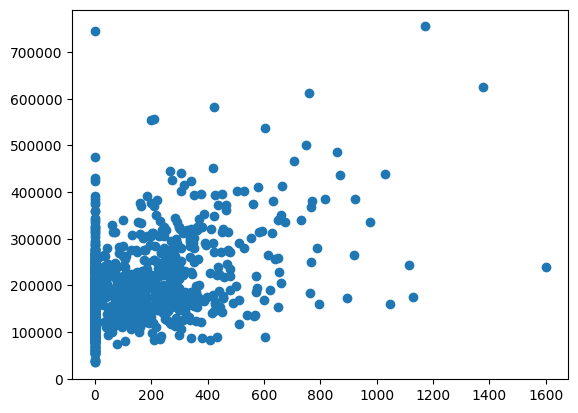

In [24]:
plt.scatter(x='MasVnrArea', y='SalePrice', data=train_df)

In [25]:
train_df.query('MasVnrArea > 1500')
#298

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
297,298,60,FV,66.0,7399,Pave,Pave,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,239000


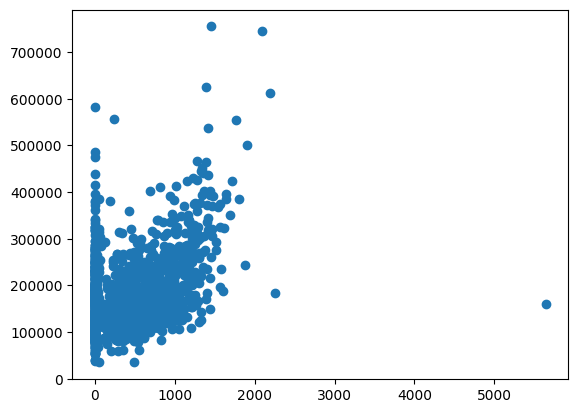

In [26]:
plt.scatter(x='BsmtFinSF1', y='SalePrice', data=train_df)

In [27]:
train_df.query('BsmtFinSF1 > 5000')
#1299


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


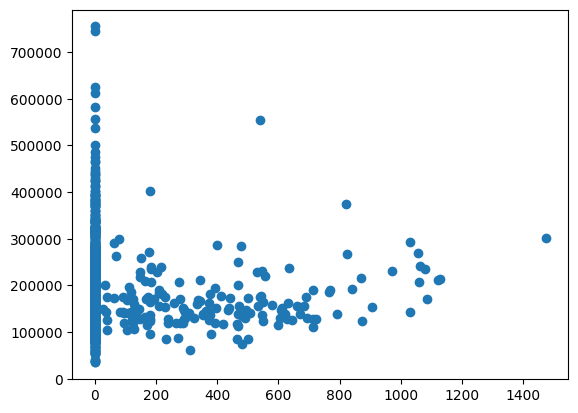

In [28]:
plt.scatter(x='BsmtFinSF2', y='SalePrice', data=train_df)

In [29]:
train_df.query('BsmtFinSF2 > 400 & SalePrice > 500000')
#441

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
440,441,20,RL,105.0,15431,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,555000


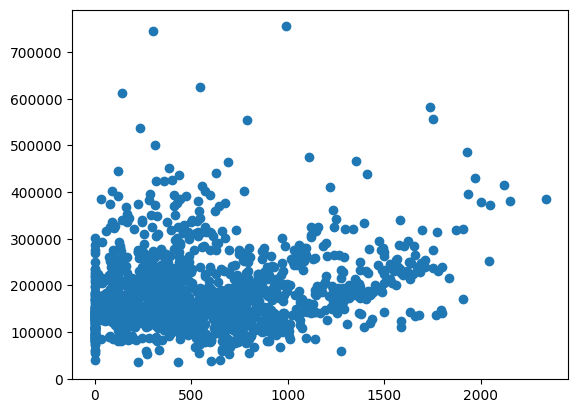

In [30]:
plt.scatter(x='BsmtUnfSF', y='SalePrice', data=train_df)

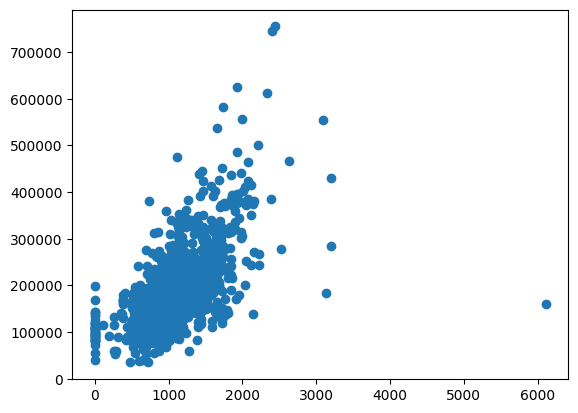

In [31]:
plt.scatter(x='TotalBsmtSF', y='SalePrice', data=train_df)

In [32]:
train_df.query('TotalBsmtSF > 5000')
#1299

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


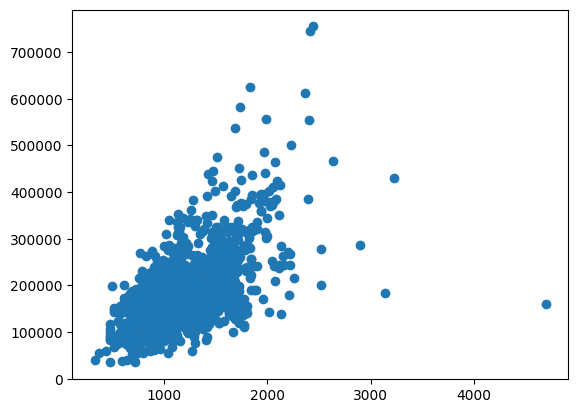

In [33]:
plt.scatter(x='1stFlrSF', y='SalePrice', data=train_df)

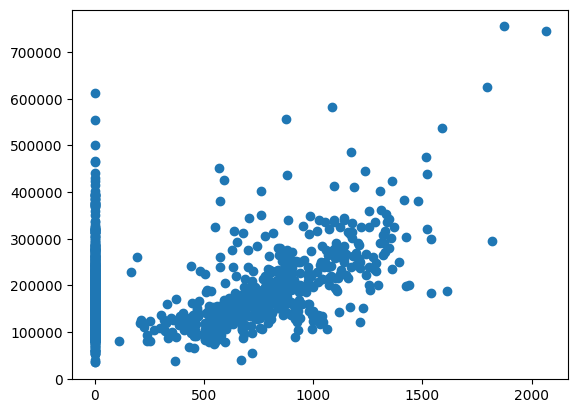

In [34]:
plt.scatter(x='2ndFlrSF', y='SalePrice', data=train_df)

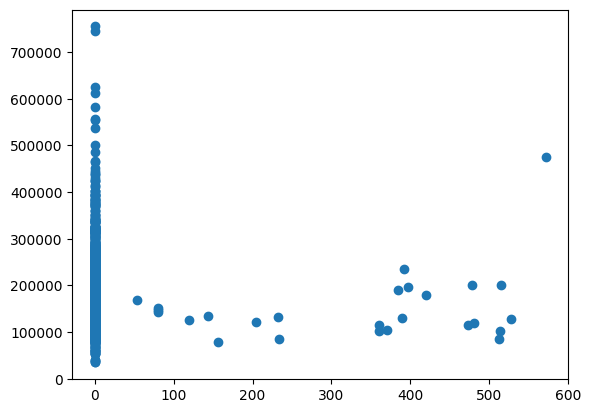

In [35]:
plt.scatter(x='LowQualFinSF', y='SalePrice', data=train_df)

In [36]:
train_df.query('LowQualFinSF > 500')
#186

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
88,89,50,C (all),105.0,8470,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,10,2009,ConLD,Abnorml,85000
170,171,50,RM,NaN,12358,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,128500
185,186,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000
635,636,190,RH,60.0,10896,Pave,Pave,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Abnorml,200000
1009,1010,50,RL,60.0,6000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,102000


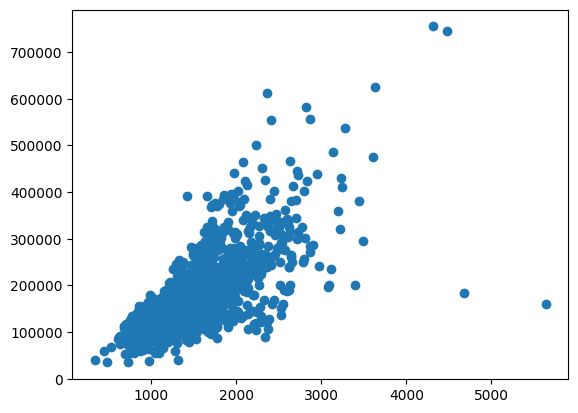

In [37]:
plt.scatter(x='GrLivArea', y='SalePrice', data=train_df)

In [38]:
train_df.query('GrLivArea > 4400')
#524, 1299

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


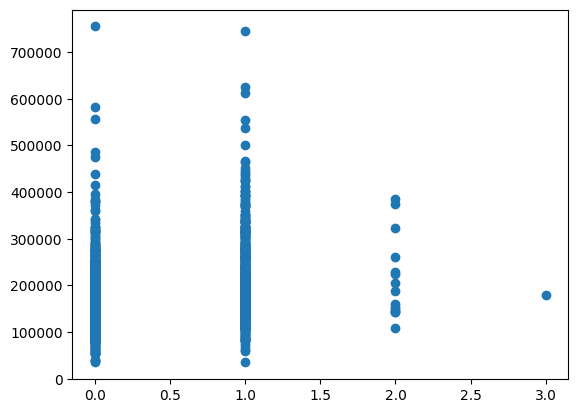

In [39]:
plt.scatter(x='BsmtFullBath', y='SalePrice', data=train_df)

In [40]:
train_df.query('BsmtFullBath == 3')
#739

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
738,739,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Alloca,179000


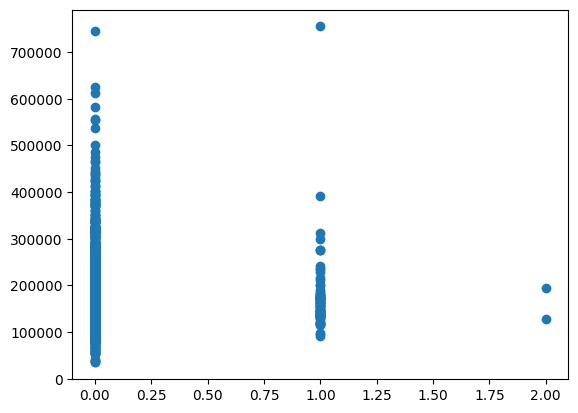

In [41]:
plt.scatter(x='BsmtHalfBath', y='SalePrice', data=train_df)

In [42]:
stats.zscore(train_df['BsmtHalfBath']).unique()

array([-0.24106104,  3.94880935,  8.13867973])

In [43]:
train_df.query('BsmtHalfBath == 2')
#598, 955

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
597,598,120,RL,53.0,3922,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2007,New,Partial,194201
954,955,90,RL,35.0,9400,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2006,WD,AdjLand,127500


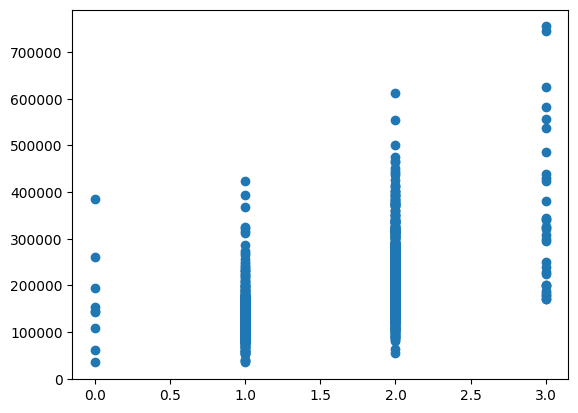

In [44]:
plt.scatter(x='FullBath', y='SalePrice', data=train_df)

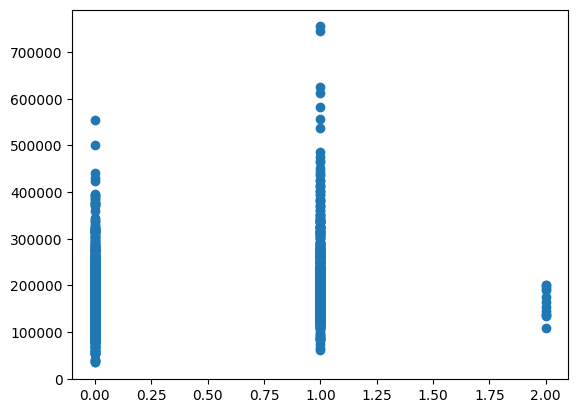

In [45]:
plt.scatter(x='HalfBath', y='SalePrice', data=train_df)

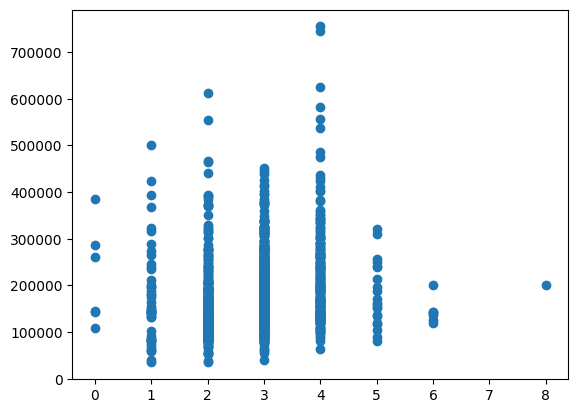

In [46]:
plt.scatter(x='BedroomAbvGr', y='SalePrice', data=train_df)

In [47]:
train_df.query('BedroomAbvGr == 8')
#636

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
635,636,190,RH,60.0,10896,Pave,Pave,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Abnorml,200000


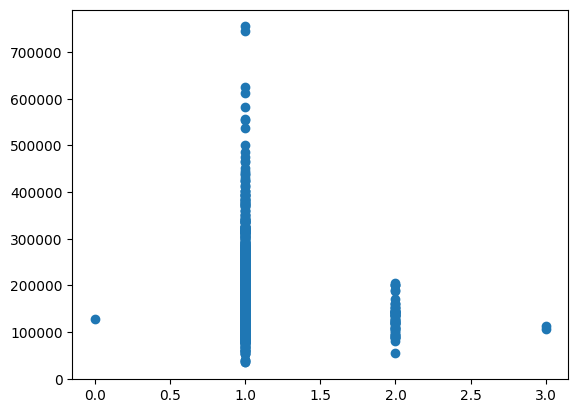

In [48]:
plt.scatter(x='KitchenAbvGr', y='SalePrice', data=train_df)

In [49]:
train_df.query('KitchenAbvGr == 3')
#49, 810

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
48,49,190,RM,33.0,4456,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,New,Partial,113000
809,810,75,RM,90.0,8100,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,11,2009,WD,Normal,106000


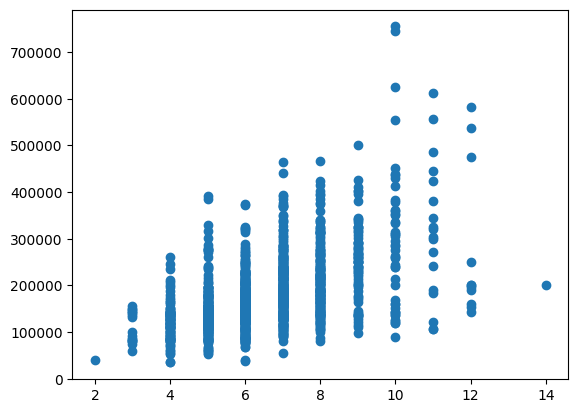

In [50]:
plt.scatter(x='TotRmsAbvGrd', y='SalePrice', data=train_df)

In [51]:
train_df.query('TotRmsAbvGrd == 14')
#636

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
635,636,190,RH,60.0,10896,Pave,Pave,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Abnorml,200000


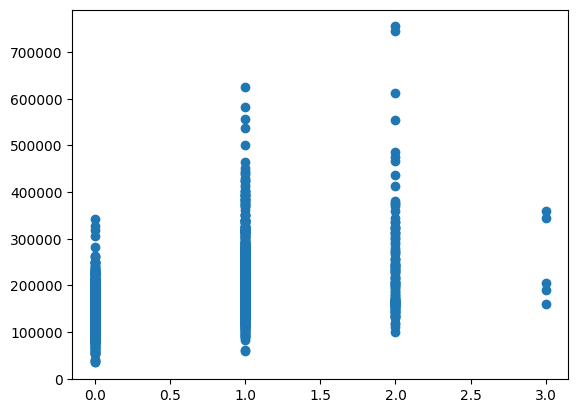

In [52]:
plt.scatter(x='Fireplaces', y='SalePrice', data=train_df)

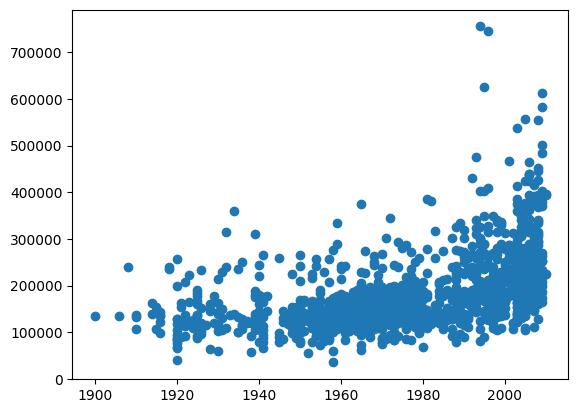

In [53]:
plt.scatter(x='GarageYrBlt', y='SalePrice', data=train_df)

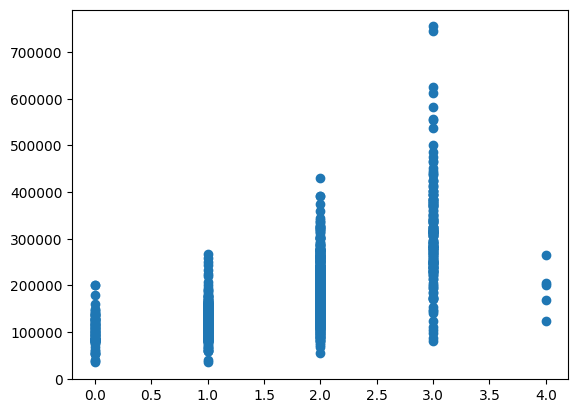

In [54]:
plt.scatter(x='GarageCars', y='SalePrice', data=train_df)


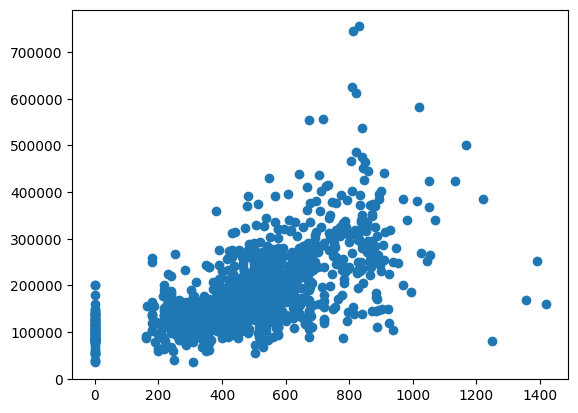

In [55]:
plt.scatter(x='GarageArea', y='SalePrice', data=train_df)

In [56]:
train_df.query('GarageArea > 1200')
#1062, 1191

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
581,582,20,RL,98.0,12704,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2009,New,Partial,253293
825,826,20,RL,114.0,14803,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,New,Partial,385000
1061,1062,30,C (all),120.0,18000,Grvl,NaN,Reg,Low,AllPub,...,0,NaN,NaN,Shed,560,8,2008,ConLD,Normal,81000
1190,1191,190,RL,NaN,32463,Pave,NaN,Reg,Low,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,168000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


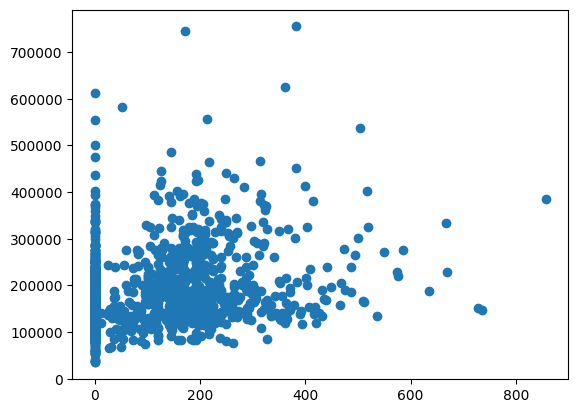

In [57]:
plt.scatter(x='WoodDeckSF', y='SalePrice', data=train_df)

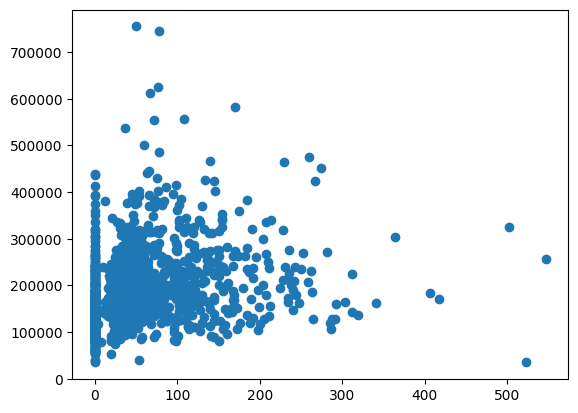

In [58]:
plt.scatter(x='OpenPorchSF', y='SalePrice', data=train_df)

In [59]:
train_df.query('OpenPorchSF > 500')
#496

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
495,496,30,C (all),60.0,7879,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,11,2009,WD,Abnorml,34900
583,584,75,RM,75.0,13500,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,325000
1328,1329,50,RM,60.0,10440,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,1150,6,2008,WD,Normal,256000


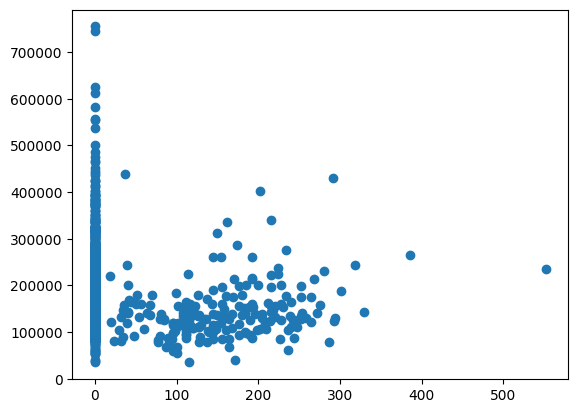

In [60]:
plt.scatter(x='EnclosedPorch', y='SalePrice', data=train_df)

In [61]:
train_df.query('EnclosedPorch > 500')
#198

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
197,198,75,RL,174.0,25419,Pave,NaN,Reg,Lvl,AllPub,...,512,Ex,GdPrv,NaN,0,3,2006,WD,Abnorml,235000


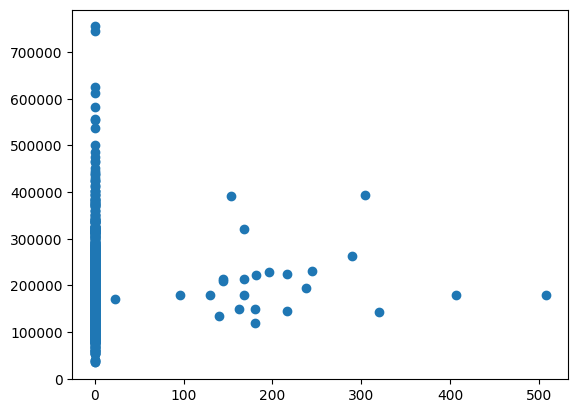

In [62]:
plt.scatter(x='3SsnPorch', y='SalePrice', data=train_df)

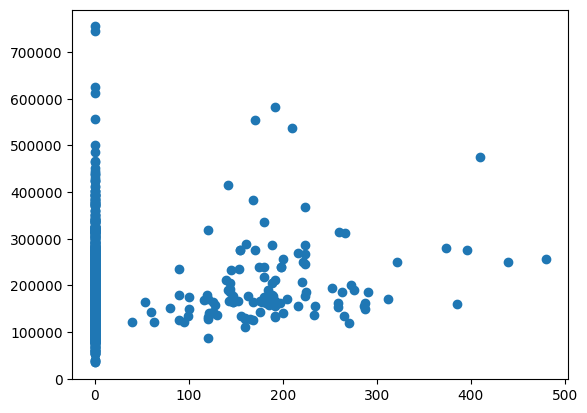

In [63]:
plt.scatter(x='ScreenPorch', y='SalePrice', data=train_df)

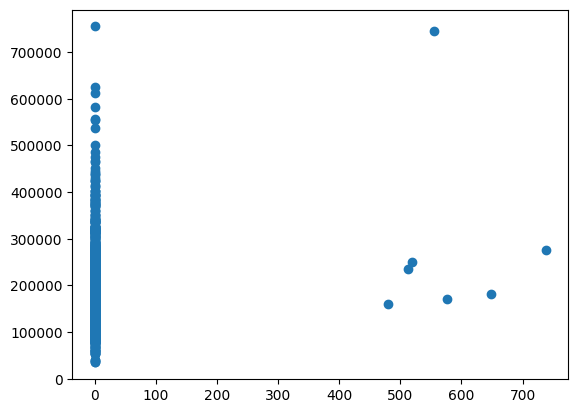

In [64]:
plt.scatter(x='PoolArea', y='SalePrice', data=train_df)

In [65]:
values = [598, 955, 935, 1299, 250, 314, 336, 707, 379, 1183, 692, 186, 441, 186, 524, 739, 598, 955, 636, 1062, 1191, 496, 198, 1338]

In [66]:
train_df = train_df[train_df.Id.isin(values) == False]

In [67]:
pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False)).head(20)

,0
PoolQC,1435
MiscFeature,1388
Alley,1350
Fence,1162
MasVnrType,861
FireplaceQu,684
LotFrontage,255
GarageYrBlt,76
GarageCond,76
GarageType,76


In [68]:
train_df['Alley'].unique()

array([nan, 'Grvl', 'Pave'], dtype=object)

In [69]:
train_df['MiscFeature'].unique()


array([nan, 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

In [70]:
train_df['Alley'].fillna('No', inplace=True)
test_df['Alley'].fillna('No', inplace=True)

/tmp/ipykernel_30/2277165759.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Alley'].fillna('No', inplace=True)
/tmp/ipykernel_30/2277165759.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

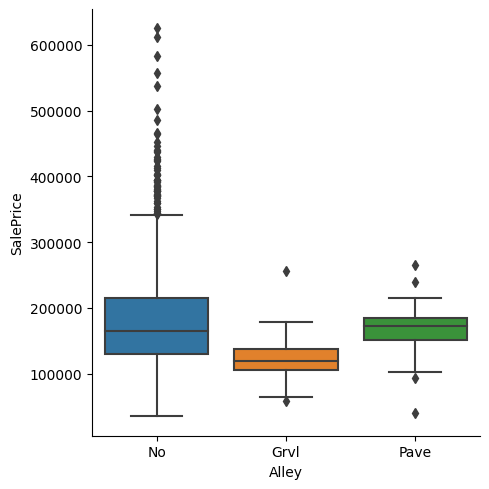

In [71]:
sns.catplot(data=train_df, x="Alley", y="SalePrice", kind="box")

In [72]:
train_df['Fence'].unique()

array([nan, 'MnPrv', 'GdWo', 'GdPrv', 'MnWw'], dtype=object)

In [73]:
train_df['Fence'].fillna('No', inplace=True)
test_df['Fence'].fillna('No', inplace=True)

/tmp/ipykernel_30/3730986352.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Fence'].fillna('No', inplace=True)
/tmp/ipykernel_30/3730986352.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

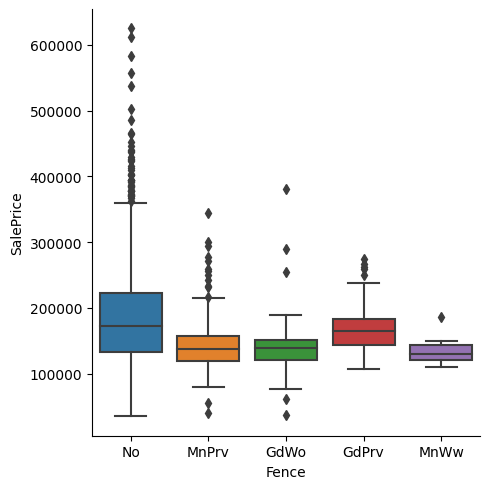

In [74]:
sns.catplot(data=train_df, x="Fence", y="SalePrice", kind="box")

In [75]:
train_df['MasVnrType'].unique()

array(['BrkFace', nan, 'Stone', 'BrkCmn'], dtype=object)

In [76]:
train_df['MasVnrType'].fillna('No', inplace=True)
test_df['MasVnrType'].fillna('No', inplace=True)

/tmp/ipykernel_30/2175816292.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['MasVnrType'].fillna('No', inplace=True)
/tmp/ipykernel_30/2175816292.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

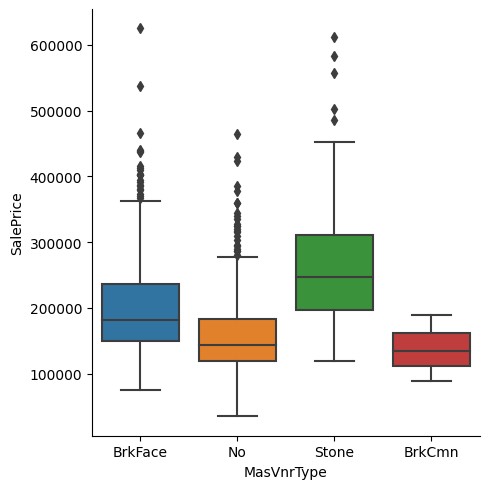

In [77]:
sns.catplot(data=train_df, x="MasVnrType", y="SalePrice", kind="box")

In [78]:
train_df['MasVnrArea'].fillna(0, inplace=True)
test_df['MasVnrArea'].fillna(0, inplace=True)

/tmp/ipykernel_30/3657060107.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['MasVnrArea'].fillna(0, inplace=True)
/tmp/ipykernel_30/3657060107.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

In [79]:
train_df['FireplaceQu'].unique()

array([nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

In [80]:
train_df['FireplaceQu'].fillna('No', inplace=True)
test_df['FireplaceQu'].fillna('No', inplace=True)

/tmp/ipykernel_30/2825947256.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['FireplaceQu'].fillna('No', inplace=True)
/tmp/ipykernel_30/2825947256.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

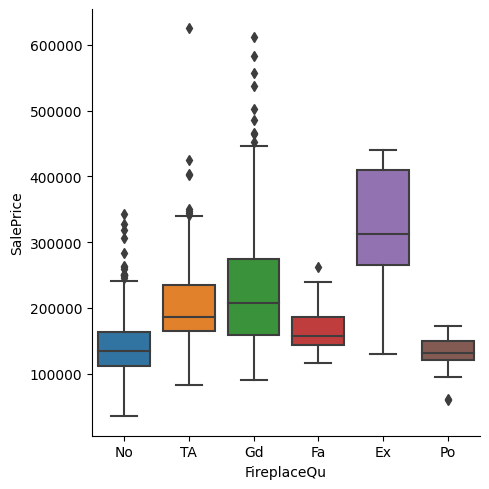

In [81]:
sns.catplot(data=train_df, x="FireplaceQu", y="SalePrice", kind="box")

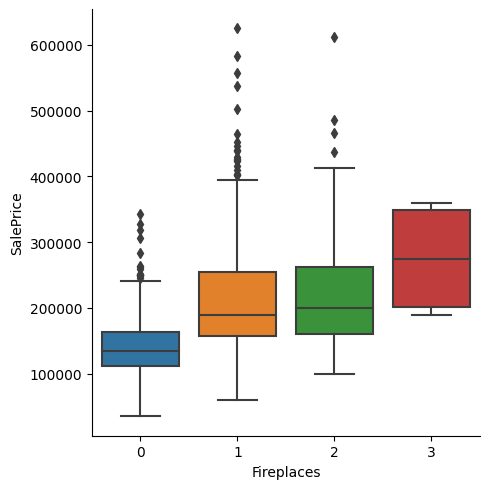

In [82]:
sns.catplot(data=train_df, x="Fireplaces", y="SalePrice", kind="box")

In [83]:
train_df['LotFrontage'].fillna(0, inplace=True)
test_df['LotFrontage'].fillna(0, inplace=True)

/tmp/ipykernel_30/1334701034.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['LotFrontage'].fillna(0, inplace=True)
/tmp/ipykernel_30/1334701034.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

In [84]:
train_df['GarageYrBlt'].corr(train_df['YearBuilt'])
#This function calculates the Pearson correlation coefficient between the two variables (columns in this case).
#The Pearson correlation coefficient measures the linear relationship between two variables and is always between -1 and 1

0.8289827595060575

In [85]:
train_df['GarageCond'].unique()

array(['TA', 'Fa', nan, 'Gd', 'Po', 'Ex'], dtype=object)

In [86]:
train_df['GarageCond'].fillna('No', inplace=True)
test_df['GarageCond'].fillna('No', inplace=True)

/tmp/ipykernel_30/1255948083.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['GarageCond'].fillna('No', inplace=True)
/tmp/ipykernel_30/1255948083.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

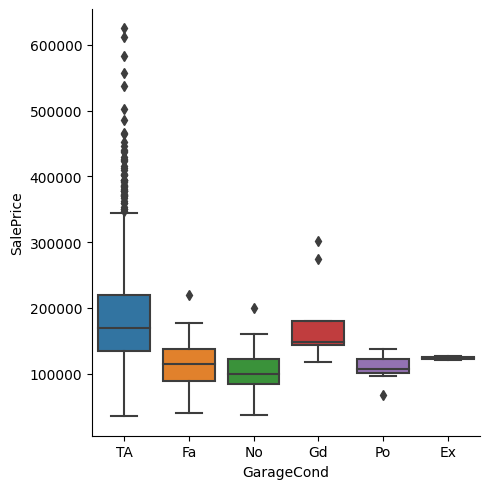

In [87]:
sns.catplot(data=train_df, x="GarageCond", y="SalePrice", kind="box")

In [88]:
train_df['GarageType'].fillna('No', inplace=True)
test_df['GarageType'].fillna('No', inplace=True)

/tmp/ipykernel_30/3721453499.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['GarageType'].fillna('No', inplace=True)
/tmp/ipykernel_30/3721453499.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

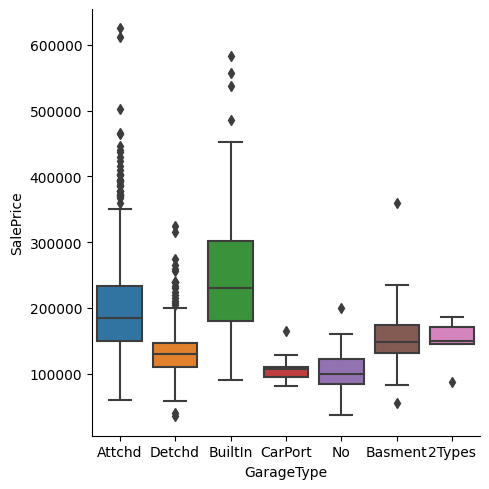

In [89]:
sns.catplot(data=train_df, x="GarageType", y="SalePrice", kind="box")

In [90]:
train_df['GarageFinish'].fillna('No', inplace=True)
test_df['GarageFinish'].fillna('No', inplace=True)

/tmp/ipykernel_30/2912414829.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['GarageFinish'].fillna('No', inplace=True)
/tmp/ipykernel_30/2912414829.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

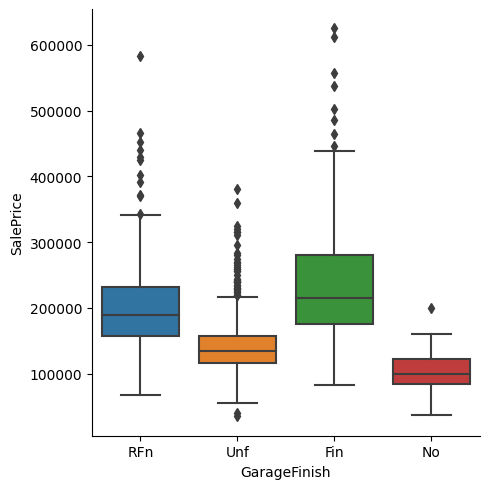

In [91]:
sns.catplot(data=train_df, x="GarageFinish", y="SalePrice", kind="box")

In [92]:
train_df['GarageQual'].fillna('No', inplace=True)
test_df['GarageQual'].fillna('No', inplace=True)

/tmp/ipykernel_30/94532614.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['GarageQual'].fillna('No', inplace=True)
/tmp/ipykernel_30/94532614.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using '

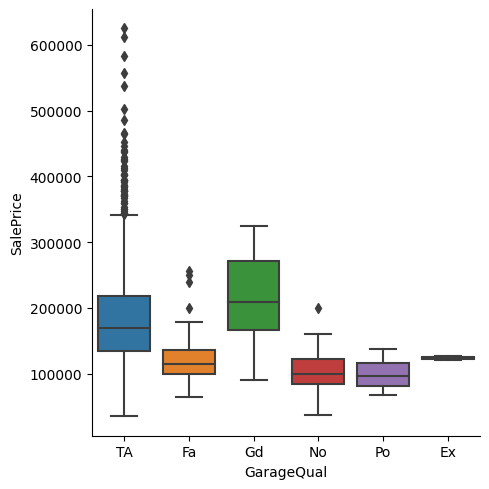

In [93]:
sns.catplot(data=train_df, x="GarageQual", y="SalePrice", kind="box")

In [94]:
train_df['BsmtFinType2'].unique()

array(['Unf', 'BLQ', nan, 'ALQ', 'Rec', 'LwQ', 'GLQ'], dtype=object)

In [95]:
train_df['BsmtFinType2'].fillna('Unf', inplace=True)
test_df['BsmtFinType2'].fillna('Unf', inplace=True)

/tmp/ipykernel_30/1071294587.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['BsmtFinType2'].fillna('Unf', inplace=True)
/tmp/ipykernel_30/1071294587.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

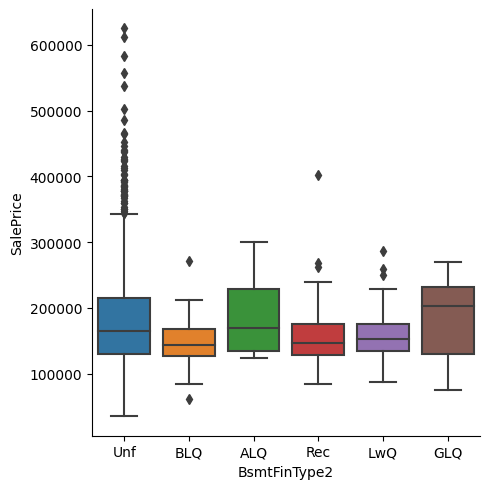

In [96]:
sns.catplot(data=train_df, x="BsmtFinType2", y="SalePrice", kind="box")

In [97]:
train_df['BsmtExposure'].unique()

array(['No', 'Gd', 'Mn', 'Av', nan], dtype=object)

In [98]:
train_df['BsmtExposure'].fillna('No', inplace=True)
test_df['BsmtExposure'].fillna('No', inplace=True)

/tmp/ipykernel_30/2040818772.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['BsmtExposure'].fillna('No', inplace=True)
/tmp/ipykernel_30/2040818772.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

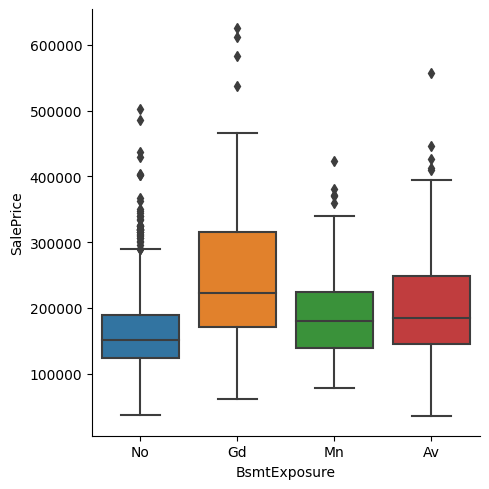

In [99]:
sns.catplot(data=train_df, x="BsmtExposure", y="SalePrice", kind="box")

In [100]:
train_df['BsmtQual'].unique()

array(['Gd', 'TA', 'Ex', nan, 'Fa'], dtype=object)

In [101]:
train_df['BsmtQual'].fillna('No', inplace=True)
test_df['BsmtQual'].fillna('No', inplace=True)

/tmp/ipykernel_30/2878576625.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['BsmtQual'].fillna('No', inplace=True)
/tmp/ipykernel_30/2878576625.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

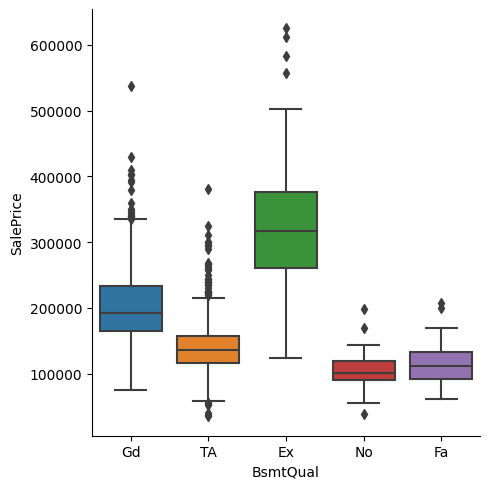

In [102]:
sns.catplot(data=train_df, x="BsmtQual", y="SalePrice", kind="box")

In [103]:
train_df['BsmtCond'].unique()

array(['TA', 'Gd', nan, 'Fa', 'Po'], dtype=object)

In [104]:
train_df['BsmtCond'].fillna('No', inplace=True)
test_df['BsmtCond'].fillna('No', inplace=True)

/tmp/ipykernel_30/2806626140.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['BsmtCond'].fillna('No', inplace=True)
/tmp/ipykernel_30/2806626140.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

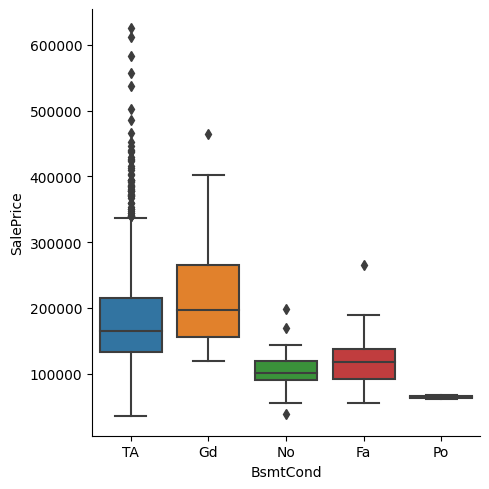

In [105]:
sns.catplot(data=train_df, x="BsmtCond", y="SalePrice", kind="box")

In [106]:
train_df['BsmtFinType1'].unique()

array(['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', nan, 'LwQ'], dtype=object)

In [107]:
train_df['BsmtFinType1'].fillna('Unf', inplace=True)
test_df['BsmtFinType1'].fillna('Unf', inplace=True)

/tmp/ipykernel_30/3531540711.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['BsmtFinType1'].fillna('Unf', inplace=True)
/tmp/ipykernel_30/3531540711.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

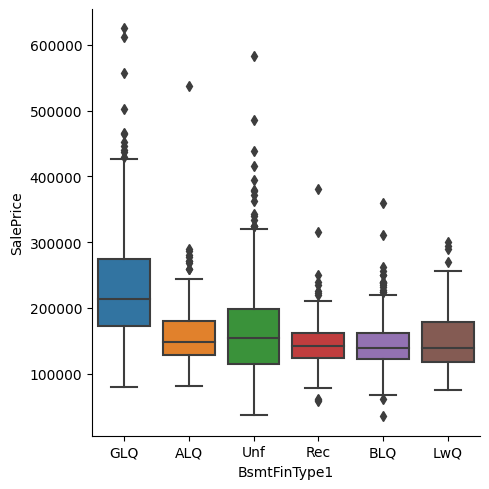

In [108]:
sns.catplot(data=train_df, x="BsmtFinType1", y="SalePrice", kind="box")

In [109]:
train_df['MasVnrArea'].fillna(0, inplace=True)
test_df['MasVnrArea'].fillna(0, inplace=True)

/tmp/ipykernel_30/3657060107.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['MasVnrArea'].fillna(0, inplace=True)
/tmp/ipykernel_30/3657060107.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

In [110]:
train_df['Electrical'].fillna('SBrkr', inplace=True)
test_df['Electrical'].fillna('SBrkr', inplace=True)

/tmp/ipykernel_30/4245203846.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Electrical'].fillna('SBrkr', inplace=True)
/tmp/ipykernel_30/4245203846.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

In [111]:
train_df = train_df.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'GarageYrBlt', 'GarageCond', 'BsmtFinType2'])
test_df = test_df.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'GarageYrBlt', 'GarageCond', 'BsmtFinType2'])

In [112]:
#feature engineering

In [113]:
train_df['houseage'] = train_df['YrSold'] - train_df['YearBuilt']
test_df['houseage'] = test_df['YrSold'] - test_df['YearBuilt']

In [114]:
train_df['houseremodelage'] = train_df['YrSold'] - train_df['YearRemodAdd']
test_df['houseremodelage'] = test_df['YrSold'] - test_df['YearRemodAdd']

In [115]:
train_df['totalsf'] = train_df['1stFlrSF'] + train_df['2ndFlrSF'] + train_df['BsmtFinSF1'] + train_df['BsmtFinSF2']
test_df['totalsf'] = test_df['1stFlrSF'] + test_df['2ndFlrSF'] + test_df['BsmtFinSF1'] + test_df['BsmtFinSF2']

In [116]:
train_df['totalarea'] = train_df['GrLivArea'] + train_df['TotalBsmtSF']
test_df['totalarea'] = test_df['GrLivArea'] + test_df['TotalBsmtSF']


In [117]:
train_df['totalbaths'] = train_df['BsmtFullBath'] + train_df['FullBath'] + 0.5 * (train_df['BsmtHalfBath'] + train_df['HalfBath']) 
test_df['totalbaths'] = test_df['BsmtFullBath'] + test_df['FullBath'] + 0.5 * (test_df['BsmtHalfBath'] + test_df['HalfBath']) 

In [118]:
train_df['totalporchsf'] = train_df['OpenPorchSF'] + train_df['3SsnPorch'] + train_df['EnclosedPorch'] + train_df['ScreenPorch'] + train_df['WoodDeckSF']
test_df['totalporchsf'] = test_df['OpenPorchSF'] + test_df['3SsnPorch'] + test_df['EnclosedPorch'] + test_df['ScreenPorch'] + test_df['WoodDeckSF']

In [119]:
train_df = train_df.drop(columns=['Id','YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'])
test_df = test_df.drop(columns=['YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'])

<Axes: >

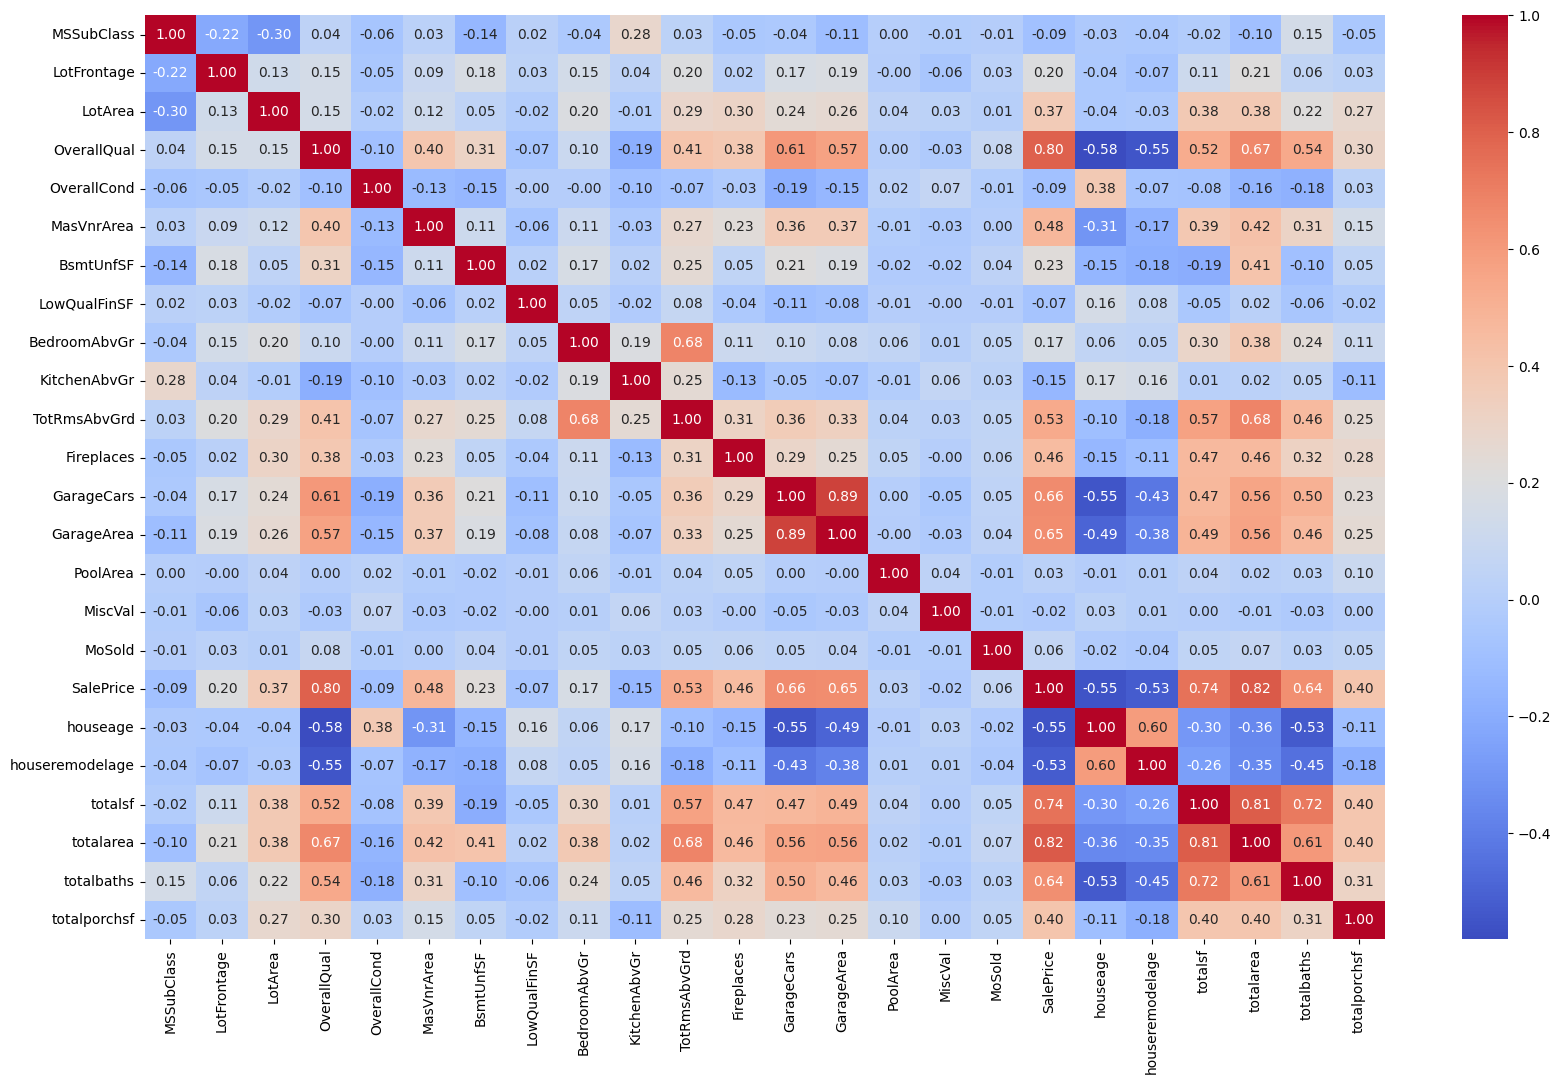

In [120]:
correlation_matrix = train_df.corr(numeric_only=True)
plt.figure(figsize=(20,12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

In [121]:
train_df = train_df.drop(columns=['GarageArea'])
test_df = test_df.drop(columns=['GarageArea'])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SalePrice', ylabel='Count'>

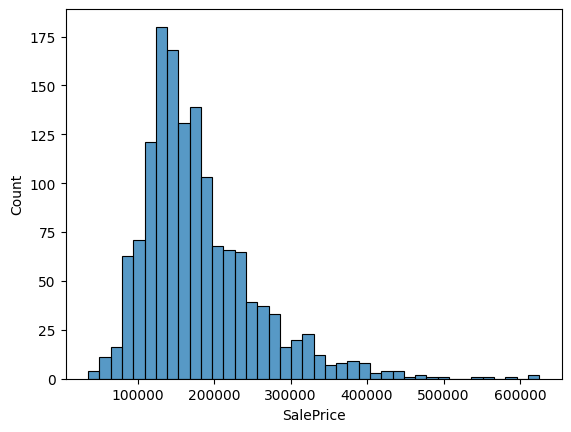

In [122]:
sns.histplot(
    train_df,
    x=train_df['SalePrice']
)

In [123]:
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SalePrice', ylabel='Count'>

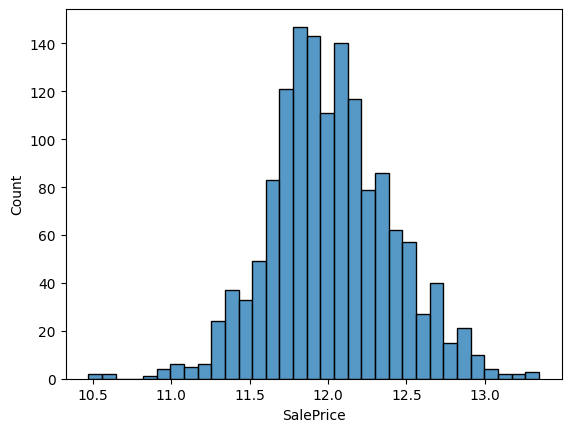

In [124]:
sns.histplot(
    train_df,
    x=train_df['SalePrice']
)

In [125]:
train_df.dtypes[train_df.dtypes=='object']

MSZoning         object
Street           object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageFinish     object
GarageQual       object
PavedDrive       object
SaleType         object
SaleCondition    object
dtype: object

In [126]:
train_df.dtypes[train_df.dtypes !='object']

MSSubClass           int64
LotFrontage        float64
LotArea              int64
OverallQual          int64
OverallCond          int64
MasVnrArea         float64
BsmtUnfSF            int64
LowQualFinSF         int64
BedroomAbvGr         int64
KitchenAbvGr         int64
TotRmsAbvGrd         int64
Fireplaces           int64
GarageCars           int64
PoolArea             int64
MiscVal              int64
MoSold               int64
SalePrice          float64
houseage             int64
houseremodelage      int64
totalsf              int64
totalarea            int64
totalbaths         float64
totalporchsf         int64
dtype: object

In [127]:
ode_cols = ['LotShape', 'LandContour','Utilities','LandSlope',  'BsmtQual',  'BsmtFinType1',  'CentralAir',  'Functional', \
           'FireplaceQu', 'GarageFinish', 'GarageQual', 'PavedDrive', 'ExterCond', 'KitchenQual', 'BsmtExposure', 'HeatingQC','ExterQual', 'BsmtCond']

In [128]:
ohe_cols = ['Street', 'LotConfig','Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', \
           'MasVnrType','Foundation',  'Electrical',  'SaleType', 'MSZoning', 'SaleCondition', 'Heating', 'GarageType', 'RoofMatl']

In [129]:
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop('SalePrice')

In [130]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [131]:
ode_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

In [132]:
ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [133]:
col_trans = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, num_cols),
    ('ode_p', ode_pipeline, ode_cols),
    ('ohe_p', ohe_pipeline, ohe_cols),
    ],
    remainder='passthrough', 
    n_jobs=-1)

In [134]:
pipeline = Pipeline(steps=[
    ('preprocessing', col_trans)
])

In [135]:
X = train_df.drop('SalePrice', axis=1)
y = train_df['SalePrice']

In [136]:
X_preprocessed = pipeline.fit_transform(X)

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=25)

In [138]:
#build models

In [139]:
lr = LinearRegression()

In [140]:
lr.fit(X_train, y_train)

LinearRegression()

In [141]:
y_pred_lr = lr.predict(X_test)

In [142]:
mean_squared_error(y_test, y_pred_lr)

3.1870250896829297e+18

In [143]:
RFR = RandomForestRegressor(random_state=13)

In [144]:
param_grid_RFR = {
    'max_depth': [5, 10, 15],
    'n_estimators': [100, 250, 500],
    'min_samples_split': [3, 5, 10]
}

In [145]:
rfr_cv = GridSearchCV(RFR, param_grid_RFR, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [146]:
rfr_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=13), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_split': [3, 5, 10],
                         'n_estimators': [100, 250, 500]},
             scoring='neg_mean_squared_error')

In [147]:
np.sqrt(-1 * rfr_cv.best_score_)

0.13392793781864115

In [148]:
rfr_cv.best_params_

{'max_depth': 15, 'min_samples_split': 3, 'n_estimators': 500}

In [149]:
XGB = XGBRegressor(random_state=13)

In [150]:
param_grid_XGB = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [300],
    'max_depth': [3],
    'min_child_weight': [1,2,3],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

In [151]:
xgb_cv = GridSearchCV(XGB, param_grid_XGB, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

In [152]:
xgb_cv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=13, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.05, 0.1, 0.2], 'max_depth': [3],
                         'min_child_weight': [1, 2, 3], 'n_estimators': [300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='neg_mean_squared_error')

In [153]:
np.sqrt(-1 * xgb_cv.best_score_)

0.11933683622521173

In [154]:
ridge = Ridge()

In [155]:
param_grid_ridge = {
    'alpha': [0.05, 0.1, 1, 3, 5, 10],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag']
}

In [156]:
ridge_cv = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [157]:
ridge_cv.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.05, 0.1, 1, 3, 5, 10],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag']},
             scoring='neg_mean_squared_error')

In [158]:
np.sqrt(-1 * ridge_cv.best_score_)

0.10909706964109693

In [159]:
GBR = GradientBoostingRegressor()

In [160]:
param_grid_GBR = {
    'max_depth': [12, 15, 20],
    'n_estimators': [200, 300, 1000],
    'min_samples_leaf': [10, 25, 50],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_features': [0.01, 0.1, 0.7]
}

In [161]:
GBR_cv = GridSearchCV(GBR, param_grid_GBR, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [162]:
GBR_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [12, 15, 20],
                         'max_features': [0.01, 0.1, 0.7],
                         'min_samples_leaf': [10, 25, 50],
                         'n_estimators': [200, 300, 1000]},
             scoring='neg_mean_squared_error')

In [163]:
np.sqrt(-1 * GBR_cv.best_score_)

0.11320107740443569

In [164]:
lgbm_regressor = lgb.LGBMRegressor()

In [165]:
param_grid_lgbm = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300]
}

In [166]:
lgbm_cv = GridSearchCV(lgbm_regressor, param_grid_lgbm, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

In [167]:
lgbm_cv.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1812
[LightGBM] [Info] Number of data points in the train set: 767, number of used features: 103
[LightGBM] [Info] Start training from score 12.016838
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1816
[LightGBM] [Info] Number of data points in the train set: 767, number of used features: 102
[LightGBM] [Info] Start training from score 12.032237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt', 'dart'],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [20, 30, 40]},
             scoring='neg_mean_squared_error')

In [168]:
np.sqrt(-1 * lgbm_cv.best_score_)

0.12728980697034

In [169]:
catboost = CatBoostRegressor(loss_function='RMSE', verbose=False)

In [170]:
param_grid_cat ={
    'iterations': [100, 500, 1000],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.5]
}

In [171]:
cat_cv = GridSearchCV(catboost, param_grid_cat, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

In [172]:
cat_cv.fit(X_train, y_train)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x78ac2ed86a10>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8, 10], 'iterations': [100, 500, 1000],
                         'learning_rate': [0.01, 0.05, 0.1, 0.5]},
             scoring='neg_mean_squared_error')

In [173]:
np.sqrt(-1 * cat_cv.best_score_)

0.11495736655121701

In [174]:
vr = VotingRegressor([('gbr', GBR_cv.best_estimator_),
                      ('xgb', xgb_cv.best_estimator_),
                      ('ridge', ridge_cv.best_estimator_)],
                    weights=[2,3,1])

In [175]:
vr.fit(X_train, y_train)

VotingRegressor(estimators=[('gbr',
                             GradientBoostingRegressor(learning_rate=0.01,
                                                       max_depth=12,
                                                       max_features=0.1,
                                                       min_samples_leaf=25,
                                                       n_estimators=1000)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.8, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_m...
                                          interaction_constraints=None,
                                          learning_rate=0.05, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=3,
                                          max_leaves=None, min_child_weight=2,
                                          missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=300,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=13, ...)),
                            ('ridge', Ridge(alpha=10, solver='lsqr'))],
                weights=[2, 3, 1])

In [176]:
y_pred_vr = vr.predict(X_test)

In [177]:
mean_squared_error(y_test, y_pred_vr, squared=False)

0.11874890313876763

In [178]:
estimators = [
    ('gbr', GBR_cv.best_estimator_),
    ('xgb', xgb_cv.best_estimator_),
    ('cat', cat_cv.best_estimator_),
    ('lgb', lgbm_cv.best_estimator_),
    ('rfr', rfr_cv.best_estimator_),
]

In [179]:
stackreg = StackingRegressor(
            estimators = estimators,
            final_estimator = vr
)

In [180]:
stackreg.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1994
[LightGBM] [Info] Number of data points in the train set: 1151, number of used features: 112
[LightGBM] [Info] Start training from score 12.023259
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1896
[LightGBM] [Info] Number of data points in the train set: 920, number of used features: 106
[LightGBM] [Info] Start training from score 12.032469
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1884
[LightGBM] [Info] Number of data points in the train set: 921, number of used features: 107
[LightGBM] [Info] Start tra

StackingRegressor(estimators=[('gbr',
                               GradientBoostingRegressor(learning_rate=0.01,
                                                         max_depth=12,
                                                         max_features=0.1,
                                                         min_samples_leaf=25,
                                                         n_estimators=1000)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval...
                                                                            interaction_constraints=None,
                                                                            learning_rate=0.05,
                                                                            max_bin=None,
                                                                            max_cat_threshold=None,
                                                                            max_cat_to_onehot=None,
                                                                            max_delta_step=None,
                                                                            max_depth=3,
                                                                            max_leaves=None,
                                                                            min_child_weight=2,
                                                                            missing=nan,
                                                                            monotone_constraints=None,
                                                                            multi_strategy=None,
                                                                            n_estimators=300,
                                                                            n_jobs=None,
                                                                            num_parallel_tree=None,
                                                                            random_state=13, ...)),
                                                              ('ridge',
                                                               Ridge(alpha=10,
                                                                     solver='lsqr'))],
                                                  weights=[2, 3, 1]))

In [181]:
y_pred_stack = stackreg.predict(X_test)

In [182]:
mean_squared_error(y_test, y_pred_stack, squared=False)

0.11511472789480415

In [183]:
df_test_preprocess = pipeline.transform(test_df)

In [185]:
y_stacking = np.exp(stackreg.predict(df_test_preprocess))

df_y_stacking_out = test_df[['Id']]
df_y_stacking_out['SalePrice'] = y_stacking

df_y_stacking_out.to_csv('submission.csv', index=False)

/tmp/ipykernel_30/176896153.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_stacking_out['SalePrice'] = y_stacking


In [186]:
import os

# Check if the file exists
file_exists = os.path.isfile('submission.csv')
print(f"File exists: {file_exists}")


File exists: True


In [ ]:
print(df_y_stacking_out.shape)  # Check the number of rows and columns
print(df_y_stacking_out.head())  # Display the first few rows
